Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


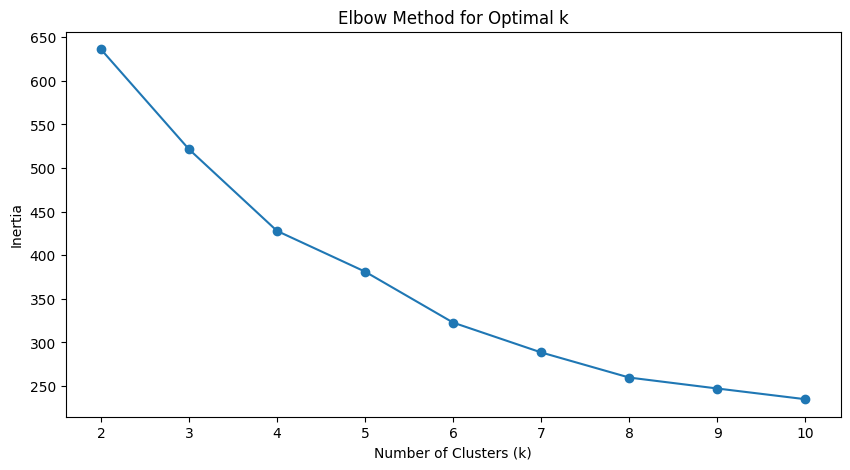

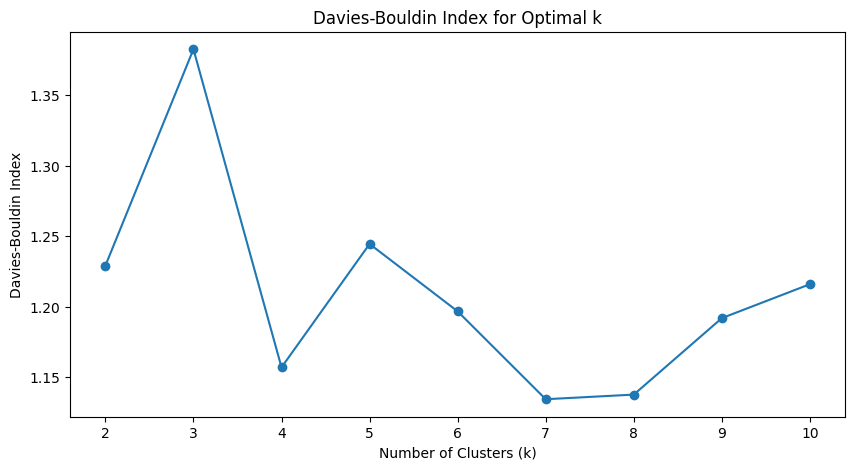

Davies-Bouldin Index for k=4: 1.1570929497715698


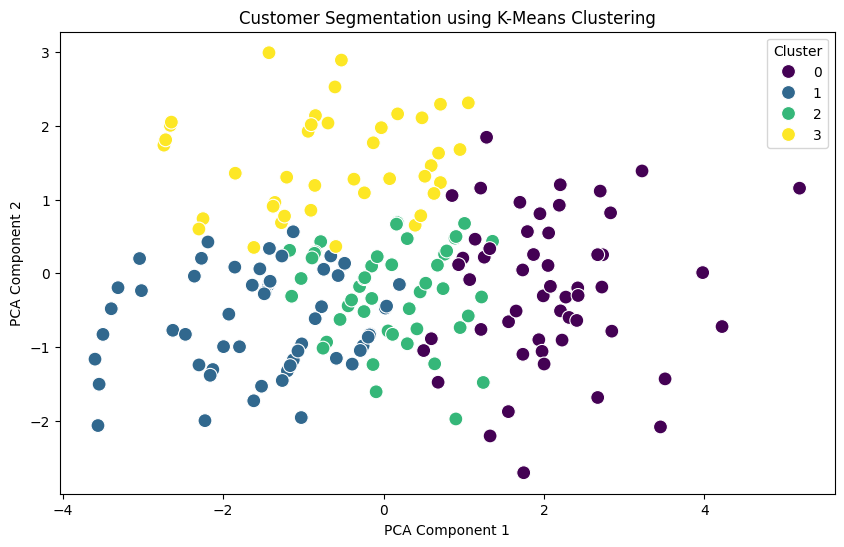


Cluster Summary:
   Cluster  total_spent_mean  avg_transaction_value_mean  \
0        0       5599.403019                  744.830572   
1        1       1793.062759                  518.513828   
2        2       3232.397292                  592.010867   
3        3       3351.862250                  971.552808   

   transaction_count_mean  unique_products_mean  signup_year_mode  
0                7.660377              7.339623              2022  
1                3.310345              3.275862              2022  
2                5.520833              5.458333              2024  
3                3.425000              3.325000              2024  


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Load datasets
customers_df = pd.read_csv("C:/Users/om wanjari/Downloads/Customers.csv")
transactions_df = pd.read_csv('C:/Users/om wanjari/Downloads/Transactions.csv')

print("Customers Data:")
print(customers_df.head())

print("\nTransactions Data:")
print(transactions_df.head())

# Merge 
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

# Feature Engineering:
customer_features = merged_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),  
    avg_transaction_value=("TotalValue", "mean"),  
    transaction_count=("TransactionID", "count"), 
    unique_products=("ProductID", "nunique"), 
    signup_year=("SignupDate", lambda x: pd.to_datetime(x).dt.year.mode()[0]) 
).reset_index()

# Merge with customer profile data
customer_features = pd.merge(customer_features, customers_df, on="CustomerID", how="left")

clustering_data = customer_features.drop(columns=["CustomerID", "CustomerName", "Region", "SignupDate"])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

#optimal number of clusters using the Elbow Method
inertia = []
db_index = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

#Davies-Bouldin Index
plt.figure(figsize=(10, 5))
plt.plot(k_values, db_index, marker="o")
plt.title("Davies-Bouldin Index for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)

customer_features["Cluster"] = kmeans.labels_

# Evaluate clustering using Davies-Bouldin Index
db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f"Davies-Bouldin Index for k={optimal_k}: {db_score}")

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
customer_features["PCA1"] = pca_data[:, 0]
customer_features["PCA2"] = pca_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=customer_features, palette="viridis", s=100)
plt.title("Customer Segmentation using K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Analyze cluster characteristics
cluster_summary = customer_features.groupby("Cluster").agg(
    total_spent_mean=("total_spent", "mean"),
    avg_transaction_value_mean=("avg_transaction_value", "mean"),
    transaction_count_mean=("transaction_count", "mean"),
    unique_products_mean=("unique_products", "mean"),
    signup_year_mode=("signup_year", lambda x: x.mode()[0])
).reset_index()

print("\nCluster Summary:")
print(cluster_summary)